In [1]:
# azureml-core of version 1.0.72 or higher is required
# azureml-dataprep[pandas] of version 1.1.34 or higher is required
from azureml.core import Workspace, Dataset
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from azureml.core import Workspace, Dataset
from azureml.core import Run
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor

subscription_id = 'ac5709b8-dd2b-46e3-98ae-bf53155e0e80'
resource_group = 'nereva_rg'
workspace_name = 'e2r2s14mls0004'

workspace = Workspace(subscription_id, resource_group, workspace_name)

dataset = Dataset.get_by_name(workspace, name='rx20_all_models')

In [2]:
def calculate_and_log_metrics(data_df, data_name='test'):
    data_df['error'] = np.abs(data_df.ground_truth - data_df.predicted)/ data_df.ground_truth
    
    return data_df

def reduce_feature_values(data_df, column, number_of_feature_values):

   all_features = data_df[column].value_counts().index

   data_df[column] = np.where(data_df[column].isin(all_features[0:min(len(all_features), number_of_feature_values)]), data_df[column], 'other')

   return data_df


def one_hot_encode_feature(df, feature_name, feature_list):
    ohe = OneHotEncoder()
    transformed = ohe.fit_transform(df[[feature_name]])
    df[[feature_name + '_' + x for x in ohe.categories_[0]]] = pd.DataFrame(transformed.toarray(),  index=df.index)
    feature_list += [feature_name + '_' + x for x in ohe.categories_[0]]
    feature_list = [x for x in feature_list if x != feature_name]
    feature_list = [x for x in feature_list if x != feature_name+'_encoded']
    return df, feature_list

In [3]:
data_df = dataset.to_pandas_dataframe()

data_df = data_df[data_df["CUSTOMER_TYPE"] == "End-Customer"]
data_df = data_df[data_df["STATUS"] > 1]
data_df = data_df[data_df["SOLD_PRICE"] > 100]
    
data_df = reduce_feature_values(data_df,column="SOLD_COUNTRY", number_of_feature_values=10)

    
features = ['OPERATING_HOURS', 'STATUS', 'AGE', 'CONSTRUCTION_YEAR' , "BLACK_FORX_FLAG","SOLD_COUNTRY", "LEASING_FLAG","KEY_ACCOUNT_FLAG","SOLD_PACKAGE_SIZE",'CAPACITY','WHEEL_QT','MAST_HEIGHT',"MAST_TYPE","MATERIAL_NR"]

data_df, features = one_hot_encode_feature(data_df, 'MAST_TYPE', features)
data_df, features = one_hot_encode_feature(data_df, 'SOLD_COUNTRY', features)
data_df, features = one_hot_encode_feature(data_df, 'SOLD_PACKAGE_SIZE', features)
data_df, features = one_hot_encode_feature(data_df, 'MATERIAL_NR', features)


features = [x for x in features if x not in ['SOLD_YEAR', 'TRADER_ID', 'CUSTOMER_TYPE_encoded', 'BLACK_FORX_FLAG']]

X_train , X_test , y_train,y_test = train_test_split(data_df,data_df["SOLD_PRICE"],test_size=0.2, random_state=42, stratify=data_df[["STATUS","MATERIAL_NR"]])

In [4]:
X = X_train.groupby('STATUS')['SOLD_PRICE'].mean()
y = pd.DataFrame()
y["STATUS"] = X.index
y["predicted"] = X.values

X_train = X_train.merge(y, on=['STATUS'])
X_train = X_train.rename(columns={"SOLD_PRICE" : "ground_truth"})
X_test = X_test.merge(y, on=['STATUS'])
X_test = X_test.rename(columns={"SOLD_PRICE" : "ground_truth"})

X_test = calculate_and_log_metrics(X_test, data_name='test')
result_baseline = X_test.copy()

In [5]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

data_df = reduce_feature_values(data_df=data_df,column="SOLD_COUNTRY",number_of_feature_values = 10)

features = ['OPERATING_HOURS', 'STATUS', 'AGE', 'CONSTRUCTION_YEAR' , "BLACK_FORX_FLAG","SOLD_COUNTRY", "LEASING_FLAG","KEY_ACCOUNT_FLAG","SOLD_PACKAGE_SIZE",'CAPACITY','WHEEL_QT','MAST_HEIGHT',"MAST_TYPE","MATERIAL_NR"]

data_df, features = one_hot_encode_feature(data_df, 'MAST_TYPE', features)
data_df, features = one_hot_encode_feature(data_df, 'SOLD_COUNTRY', features)
data_df, features = one_hot_encode_feature(data_df, 'SOLD_PACKAGE_SIZE', features)
data_df, features = one_hot_encode_feature(data_df, 'MATERIAL_NR', features)


features = [x for x in features if x not in ['SOLD_YEAR', 'TRADER_ID', 'CUSTOMER_TYPE_encoded', 'BLACK_FORX_FLAG']]




X_train , X_test , y_train,y_test = train_test_split(data_df,data_df["SOLD_PRICE"],test_size=0.2, random_state=42, stratify=data_df[["STATUS","MATERIAL_NR"]])

   
    #input_model = ['OPERATING_HOURS', 'STATUS', 'AGE', 'CONSTRUCTION_YEAR' , "BLACK_FORX_FLAG","SOLD_COUNTRY_encoded", "LEASING_FLAG","KEY_ACCOUNT_FLAG","SOLD_PACKAGE_SIZE_encoded",'CAPACITY','WHEEL_QT','MAST_HEIGHT',"MAST_TYPE_encoded"]

linear_reg = Pipeline([
    ("Scaling", StandardScaler(with_mean=False)),
    ("Linear Regression", LinearRegression())
])

linear_reg.fit(X_train[features], y_train)

predictions = linear_reg.predict(X_test[features])
    
print('Training Done')
# Rate Model
X_test['ground_truth'] = y_test
X_test['predicted'] = predictions
X_test = calculate_and_log_metrics(X_test, data_name='test')
result_basic = X_test.copy()

Training Done


In [6]:
from sklearn.tree import DecisionTreeRegressor

data_df = data_df[data_df["CUSTOMER_TYPE"] == "End-Customer"]
data_df = data_df[data_df["STATUS"] > 1]
data_df = data_df[data_df["SOLD_PRICE"] > 100]
    
data_df = reduce_feature_values(data_df,column="SOLD_COUNTRY", number_of_feature_values=10)

    
features = ['OPERATING_HOURS', 'STATUS', 'AGE', 'CONSTRUCTION_YEAR' , "BLACK_FORX_FLAG","SOLD_COUNTRY", "LEASING_FLAG","KEY_ACCOUNT_FLAG","SOLD_PACKAGE_SIZE",'CAPACITY','WHEEL_QT','MAST_HEIGHT',"MAST_TYPE","MATERIAL_NR"]

data_df, features = one_hot_encode_feature(data_df, 'MAST_TYPE', features)
data_df, features = one_hot_encode_feature(data_df, 'SOLD_COUNTRY', features)
data_df, features = one_hot_encode_feature(data_df, 'SOLD_PACKAGE_SIZE', features)
data_df, features = one_hot_encode_feature(data_df, 'MATERIAL_NR', features)


features = [x for x in features if x not in ['SOLD_YEAR', 'TRADER_ID', 'CUSTOMER_TYPE_encoded', 'BLACK_FORX_FLAG']]

X_train , X_test , y_train,y_test = train_test_split(data_df,data_df["SOLD_PRICE"],test_size=0.2, random_state=42, stratify=data_df[["STATUS","MATERIAL_NR"]])



     
dt = DecisionTreeRegressor(random_state=0)


dt.fit(X_train[features], y_train)

predictions = dt.predict(X_test[features])

X_test['ground_truth'] = y_test
X_test['predicted'] = predictions
X_test = calculate_and_log_metrics(X_test, data_name='test')
result_dt = X_test.copy()


/anaconda/envs/azureml_py36/lib/python3.6/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/anaconda/envs/azureml_py36/lib/python3.6/site-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/anaconda/envs/azureml_py36/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

In [7]:
data_df = data_df[data_df["CUSTOMER_TYPE"] == "End-Customer"]
data_df = data_df[data_df["STATUS"] > 1]
data_df = data_df[data_df["SOLD_PRICE"] > 100]
    
data_df = reduce_feature_values(data_df,column="SOLD_COUNTRY", number_of_feature_values=10)

    
features = ['OPERATING_HOURS', 'STATUS', 'AGE', 'CONSTRUCTION_YEAR' , "BLACK_FORX_FLAG","SOLD_COUNTRY", "LEASING_FLAG","KEY_ACCOUNT_FLAG","SOLD_PACKAGE_SIZE",'CAPACITY','WHEEL_QT','MAST_HEIGHT',"MAST_TYPE","MATERIAL_NR"]

data_df, features = one_hot_encode_feature(data_df, 'MAST_TYPE', features)
data_df, features = one_hot_encode_feature(data_df, 'SOLD_COUNTRY', features)
data_df, features = one_hot_encode_feature(data_df, 'SOLD_PACKAGE_SIZE', features)
data_df, features = one_hot_encode_feature(data_df, 'MATERIAL_NR', features)


features = [x for x in features if x not in ['SOLD_YEAR', 'TRADER_ID', 'CUSTOMER_TYPE_encoded', 'BLACK_FORX_FLAG']]
    
    
X_train , X_test , y_train,y_test = train_test_split(data_df,data_df["SOLD_PRICE"],test_size=0.2, random_state=42, stratify=data_df[["STATUS","MATERIAL_NR"]])



     
rfr = RandomForestRegressor(random_state=42)

rfr.fit(X_train[features], y_train)
predictions = rfr.predict(X_test[features])
    

X_test['ground_truth'] = y_test
X_test['predicted'] = predictions
X_test = calculate_and_log_metrics(X_test, data_name='test')

results_rfr = X_test.copy()


/anaconda/envs/azureml_py36/lib/python3.6/site-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/anaconda/envs/azureml_py36/lib/python3.6/site-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/anaconda/envs/azureml_py36/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

In [8]:
import xgboost as xgb

def median_rel_error_metric(predt, dtrain):
    ''' Root mean squared log error metric.'''
    y = dtrain.get_label()
    success_rate = np.median((np.abs(predt-y) / y))
    return 'median_rel_error', success_rate

features = ['OPERATING_HOURS', 'STATUS', 'AGE', 'CONSTRUCTION_YEAR' , "BLACK_FORX_FLAG","SOLD_COUNTRY", "LEASING_FLAG","KEY_ACCOUNT_FLAG","SOLD_PACKAGE_SIZE",'CAPACITY','WHEEL_QT','MAST_HEIGHT',"MAST_TYPE","MATERIAL_NR"]

data_df, features = one_hot_encode_feature(data_df, 'MAST_TYPE', features)
data_df, features = one_hot_encode_feature(data_df, 'SOLD_COUNTRY', features)
data_df, features = one_hot_encode_feature(data_df, 'SOLD_PACKAGE_SIZE', features)
data_df, features = one_hot_encode_feature(data_df, 'MATERIAL_NR', features)


features = [x for x in features if x not in ['SOLD_YEAR', 'TRADER_ID', 'CUSTOMER_TYPE_encoded', 'BLACK_FORX_FLAG']]
    
X_train , X_test , y_train,y_test = train_test_split(data_df,data_df[["STATUS","SOLD_PRICE"]],test_size=0.2, random_state=42, stratify=data_df[["STATUS","MATERIAL_NR"]])

     
progress = {}
train_dmatrix = xgb.DMatrix(data=X_train[features], label=y_train["SOLD_PRICE"])
test_dmatrix = xgb.DMatrix(data=X_test[features], label=y_test["SOLD_PRICE"])
model = xgb.train({'tree_method': 'hist',
        'disable_default_eval_metric': 1},
        dtrain=train_dmatrix,
        feval = median_rel_error_metric,
        #early_stopping_rounds = 10,
        #num_boost_round=400,
        evals=[(train_dmatrix, 'dtrain'), (test_dmatrix, 'dtest')],
        evals_result=progress
    )

predictions = model.predict(test_dmatrix)
X_test['ground_truth'] = y_test["SOLD_PRICE"]
X_test['predicted'] = predictions
X_test = calculate_and_log_metrics(X_test, data_name='test')
results_xgb = X_test.copy()

[0]	dtrain-median_rel_error:0.697125	dtest-median_rel_error:0.699312
[1]	dtrain-median_rel_error:0.491753	dtest-median_rel_error:0.493247
[2]	dtrain-median_rel_error:0.350217	dtest-median_rel_error:0.353218
[3]	dtrain-median_rel_error:0.259771	dtest-median_rel_error:0.266911
[4]	dtrain-median_rel_error:0.202688	dtest-median_rel_error:0.211766
[5]	dtrain-median_rel_error:0.170097	dtest-median_rel_error:0.181608
[6]	dtrain-median_rel_error:0.149108	dtest-median_rel_error:0.16418
[7]	dtrain-median_rel_error:0.13809	dtest-median_rel_error:0.152898
[8]	dtrain-median_rel_error:0.133822	dtest-median_rel_error:0.145769
[9]	dtrain-median_rel_error:0.128765	dtest-median_rel_error:0.145069


In [9]:
import xgboost as xgb

def median_rel_error_metric(predt, dtrain):
    ''' Root mean squared log error metric.'''
    y = dtrain.get_label()
    success_rate = np.median((np.abs(predt-y) / y))
    return 'median_rel_error', success_rate

features = ['OPERATING_HOURS', 'STATUS', 'AGE', 'CONSTRUCTION_YEAR' , "BLACK_FORX_FLAG","SOLD_COUNTRY", "LEASING_FLAG","KEY_ACCOUNT_FLAG","SOLD_PACKAGE_SIZE",'CAPACITY','WHEEL_QT','MAST_HEIGHT',"MAST_TYPE","MATERIAL_NR"]

data_df, features = one_hot_encode_feature(data_df, 'MAST_TYPE', features)
data_df, features = one_hot_encode_feature(data_df, 'SOLD_COUNTRY', features)
data_df, features = one_hot_encode_feature(data_df, 'SOLD_PACKAGE_SIZE', features)
data_df, features = one_hot_encode_feature(data_df, 'MATERIAL_NR', features)


features = [x for x in features if x not in ['SOLD_YEAR', 'TRADER_ID', 'CUSTOMER_TYPE_encoded', 'BLACK_FORX_FLAG']]
    
X_train , X_test , y_train,y_test = train_test_split(data_df,data_df[["STATUS","SOLD_PRICE"]],test_size=0.2, random_state=42, stratify=data_df[["STATUS","MATERIAL_NR"]])

     
progress = {}
train_dmatrix_second = xgb.DMatrix(data=X_train[features], label=y_train["SOLD_PRICE"])
test_dmatrix_second  = xgb.DMatrix(data=X_test[features], label=y_test["SOLD_PRICE"])
model_second = xgb.train({'tree_method': 'hist',
        'disable_default_eval_metric': 1},
        dtrain=train_dmatrix_second ,
        feval = median_rel_error_metric,
        early_stopping_rounds = 10,
        num_boost_round=100,
        evals=[(train_dmatrix_second , 'dtrain'), (test_dmatrix_second , 'dtest')],
        evals_result=progress
    )

predictions = model_second.predict(test_dmatrix_second )
X_test['ground_truth'] = y_test["SOLD_PRICE"]
X_test['predicted'] = predictions
X_test = calculate_and_log_metrics(X_test, data_name='test')
results_xgb_early = X_test.copy()

[0]	dtrain-median_rel_error:0.697125	dtest-median_rel_error:0.699312
Multiple eval metrics have been passed: 'dtest-median_rel_error' will be used for early stopping.

Will train until dtest-median_rel_error hasn't improved in 10 rounds.
[1]	dtrain-median_rel_error:0.491753	dtest-median_rel_error:0.493247
[2]	dtrain-median_rel_error:0.350217	dtest-median_rel_error:0.353218
[3]	dtrain-median_rel_error:0.259771	dtest-median_rel_error:0.266911
[4]	dtrain-median_rel_error:0.202688	dtest-median_rel_error:0.211766
[5]	dtrain-median_rel_error:0.170097	dtest-median_rel_error:0.181608
[6]	dtrain-median_rel_error:0.149108	dtest-median_rel_error:0.16418
[7]	dtrain-median_rel_error:0.13809	dtest-median_rel_error:0.152898
[8]	dtrain-median_rel_error:0.133822	dtest-median_rel_error:0.145769
[9]	dtrain-median_rel_error:0.128765	dtest-median_rel_error:0.145069
[10]	dtrain-median_rel_error:0.126491	dtest-median_rel_error:0.143677
[11]	dtrain-median_rel_error:0.126317	dtest-median_rel_error:0.143989
[12

/anaconda/envs/azureml_py36/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/anaconda/envs/azureml_py36/lib/python3.6/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \
/anaconda/envs/azureml_py36/lib/python3.6/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/anaconda/envs/azureml_py36/lib/python3.6/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_

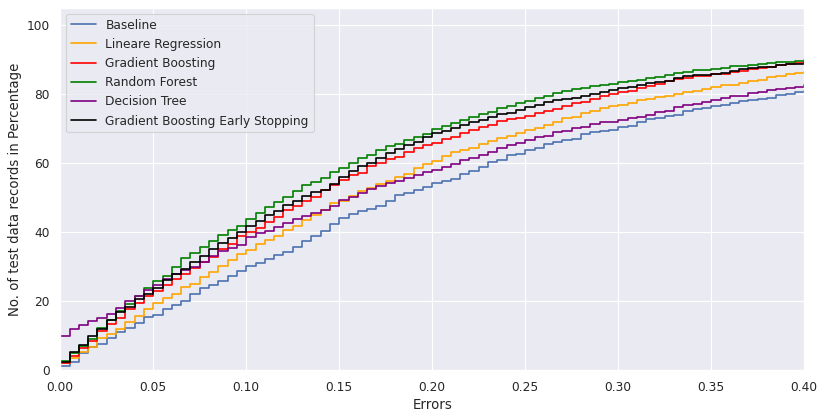

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()
plt.figure(figsize=(12, 6), dpi=80)
bins = np.arange(0, 1, 0.005)
sns.histplot(result_baseline.query('error < 1.0').error, label='Baseline', element='step', stat='percent', fill=False, bins=bins, cumulative=True)
sns.histplot(result_basic.query('error < 1.0').error, label='Lineare Regression', element='step', stat='percent', fill=False, color='orange', bins=bins, cumulative=True)
sns.histplot(results_xgb.query('error < 1.0').error, label='Gradient Boosting', element='step', stat='percent', fill=False, color='red', bins=bins, cumulative=True)
sns.histplot(results_rfr.query('error < 1.0').error, label='Random Forest', element='step', stat='percent', fill=False, color='green', bins=bins, cumulative=True)
sns.histplot(result_dt.query('error < 1.0').error, label='Decision Tree', element='step', stat='percent', fill=False, color='purple', bins=bins, cumulative=True)
sns.histplot(results_xgb_early.query('error < 1.0').error, label='Gradient Boosting Early Stopping', element='step', stat='percent', fill=False, color='black', bins=bins, cumulative=True)

plt.legend()
plt.legend()
plt.style.use('fivethirtyeight')
plt.ylabel('No. of test data records in Percentage')
plt.xlabel('Errors')
plt.xlim([0, 0.4])
plt.show()

In [11]:
data_df = data_df[data_df["CUSTOMER_TYPE"] == "End-Customer"]
data_df = data_df[data_df["STATUS"] > 1]
data_df = data_df[data_df["SOLD_PRICE"] > 100]
    
data_df = reduce_feature_values(data_df,column="SOLD_COUNTRY", number_of_feature_values=10)

    
features = ['OPERATING_HOURS', 'STATUS', 'AGE', 'CONSTRUCTION_YEAR' , "BLACK_FORX_FLAG","SOLD_COUNTRY", "LEASING_FLAG","KEY_ACCOUNT_FLAG","SOLD_PACKAGE_SIZE",'CAPACITY','WHEEL_QT','MAST_HEIGHT',"MAST_TYPE","MATERIAL_NR"]

data_df, features = one_hot_encode_feature(data_df, 'MAST_TYPE', features)
data_df, features = one_hot_encode_feature(data_df, 'SOLD_COUNTRY', features)
data_df, features = one_hot_encode_feature(data_df, 'SOLD_PACKAGE_SIZE', features)
data_df, features = one_hot_encode_feature(data_df, 'MATERIAL_NR', features)


features = [x for x in features if x not in ['SOLD_YEAR', 'TRADER_ID', 'CUSTOMER_TYPE_encoded', 'BLACK_FORX_FLAG']]
    
    
X_train , X_test , y_train,y_test = train_test_split(data_df,data_df["SOLD_PRICE"],test_size=0.2, random_state=42, stratify=data_df[["STATUS","MATERIAL_NR"]])



     
rfr = RandomForestRegressor(random_state=42,max_depth=32,max_features=0.6,min_samples_split=5,n_estimators=200)

rfr.fit(X_train[features], y_train)
predictions = rfr.predict(X_test[features])
    

X_test['ground_truth'] = y_test
X_test['predicted'] = predictions
X_test = calculate_and_log_metrics(X_test, data_name='test')

results_rfr_hyp = X_test.copy()

/anaconda/envs/azureml_py36/lib/python3.6/site-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/anaconda/envs/azureml_py36/lib/python3.6/site-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/anaconda/envs/azureml_py36/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

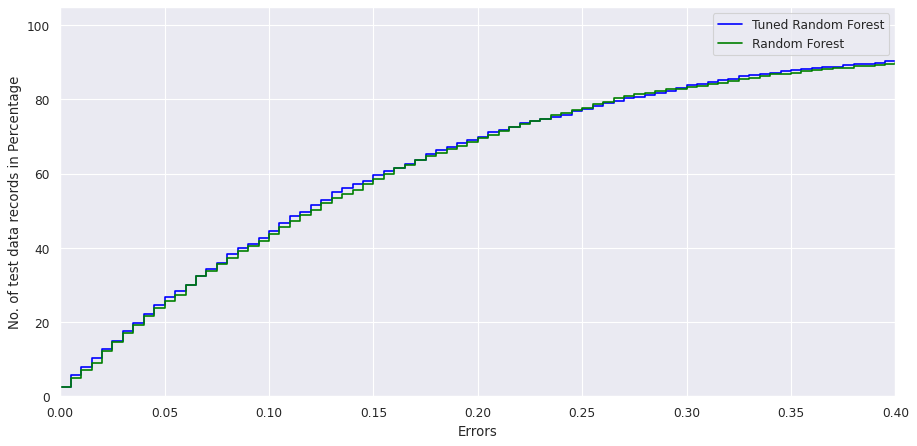

In [12]:
sns.set()
plt.figure(figsize=(12, 6), dpi=80)
bins = np.arange(0, 1, 0.005)
sns.histplot(results_rfr_hyp.query('error < 1.0').error, label='Tuned Random Forest', element='step', stat='percent', fill=False, color='blue', bins=bins, cumulative=True)
sns.histplot(results_rfr.query('error < 1.0').error, label='Random Forest', element='step', stat='percent', fill=False, color='green', bins=bins, cumulative=True)
plt.legend()
plt.legend()
plt.style.use('fivethirtyeight')
plt.ylabel('No. of test data records in Percentage')
plt.xlabel('Errors')
plt.xlim([0, 0.4])
plt.show()